# voting_ensemble_soft

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

from sklearn.ensemble         import VotingClassifier

from sklearn.ensemble         import GradientBoostingClassifier
from sklearn.ensemble         import ExtraTreesClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.linear_model     import LogisticRegressionCV
import xgboost as xgb

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [16]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = False

N_CLASSES = 2

submission_filename = "../submissions/submission_voting_ensemble_softWgtd.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [5]:
%%time

random.seed(SEED)

# -------------------------------- estimators ----------------------------------------
gbc = GradientBoostingClassifier(loss                     = 'exponential',
                                 learning_rate            = 0.15, 
                                 n_estimators             = 175, 
                                 max_depth                = 1, 
                                 subsample                = 0.75, 
                                 
                                 min_samples_split        = 2, 
                                 min_samples_leaf         = 1, 
                                 #min_weight_fraction_leaf = 0.0, 
                                 init                     = None, 
                                 random_state             = SEED, 
                                 max_features             = None, 
                                 verbose                  = 0, 
                                 max_leaf_nodes           = None, 
                                 warm_start               = False) 
                                 #presort                  = 'auto')
    
etc = ExtraTreesClassifier(n_estimators             = 10, 
                           criterion                = 'entropy', 
                           max_depth                = 7, 
                           bootstrap                = True, 
                           max_features             = None,
                           
                           min_samples_split        = 2, 
                           min_samples_leaf         = 1, 
                           #min_weight_fraction_leaf = 0.0, 
                            
                           max_leaf_nodes           = None, 
                           oob_score                = False, 
                           n_jobs                   = -1, 
                           random_state             = SEED, 
                           verbose                  = 0) 
                           #warm_start               = False, 
                           #class_weight             = None)
        
xgbc = xgb.XGBClassifier(learning_rate    = 0.1,
                         n_estimators     = 50, 
                         max_depth        = 5,
                         subsample        = 0.25,
                         colsample_bytree = 0.75,
                         gamma            = 0, 
                        
                         nthread          = 1, 
                         objective        = 'binary:logistic', 
                         min_child_weight = 1, 
                         max_delta_step   = 0, 
                         base_score       = 0.5, 
                         seed             = SEED,
                         silent           = True,
                         missing          = None)

logit = LogisticRegression(penalty           = 'l2',          
                         dual              = False, 
                         C                 = 0.001, 
                         fit_intercept     = True,
                         solver            = 'liblinear',   
                         max_iter          = 50, 
                         intercept_scaling = 1,
                         
                         tol               = 0.0001, 
                         class_weight      = None, 
                         random_state      = SEED, 
                         multi_class       = 'ovr', 
                         verbose           = 0, 
                         warm_start        = False, 
                         n_jobs            = -1)

logitCV = LogisticRegressionCV(Cs            = 10, 
                           cv                = 10,
                           
                           fit_intercept     = True, 
                           penalty           = 'l2',
                           solver            = 'liblinear', 
                           max_iter          = 50,
                            
                           dual              = False, 
                           scoring           = None, 
                           tol               = 0.0001, 
                           class_weight      = None, 
                           n_jobs            = -1, 
                           verbose           = 0, 
                           refit             = True, 
                           intercept_scaling = 1.0, 
                           multi_class       = 'ovr', 
                           random_state      = SEED)

# -------------------------------- VotingClassifier ----------------------------------------

estimator_list = [('gbc', gbc), ('etc', etc), ('xgbc', xgbc), ('logit', logit), ('logitCV',logitCV)]
weights_list   = [      1,          0.75,           0.75,               2,                  1]

clf = VotingClassifier(estimators = estimator_list, 
                       voting     = 'soft', 
                       weights    = weights_list)

clf.fit(X_train, y_train)

CPU times: user 164 ms, sys: 20 ms, total: 184 ms
Wall time: 401 ms


In [6]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

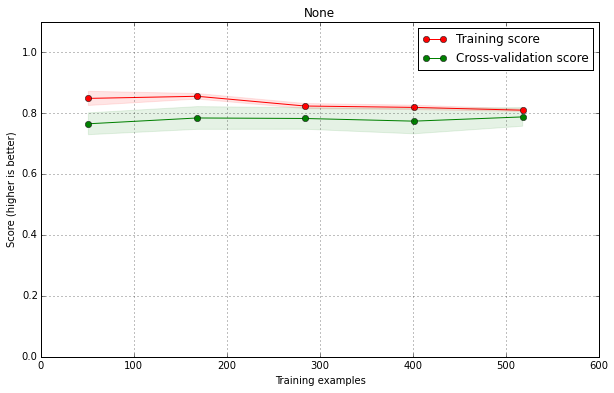

CPU times: user 7.36 s, sys: 1.49 s, total: 8.85 s
Wall time: 31 s


In [7]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = 1)

plt.show()

# Training set predictions

In [8]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train, 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = 1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 1.64 s, sys: 276 ms, total: 1.92 s
Wall time: 5.23 s


[[417  21]
 [102  36]]


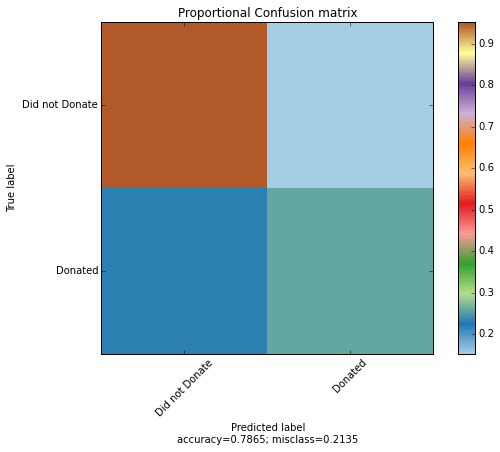

Accuracy 0.7865, mis-class rate 0.2135


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

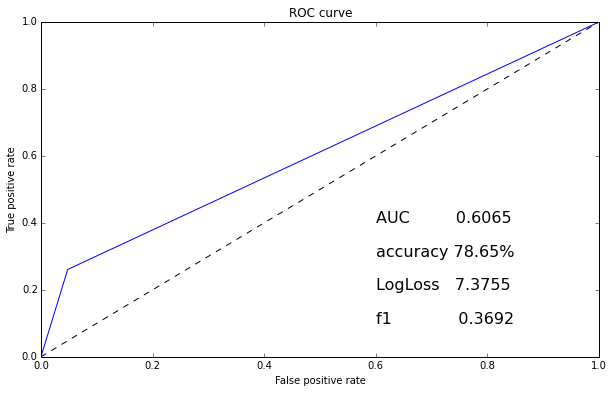

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [11]:
%%time

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = 1) 



CPU times: user 2min 40s, sys: 29.1 s, total: 3min 9s
Wall time: 8min 44s


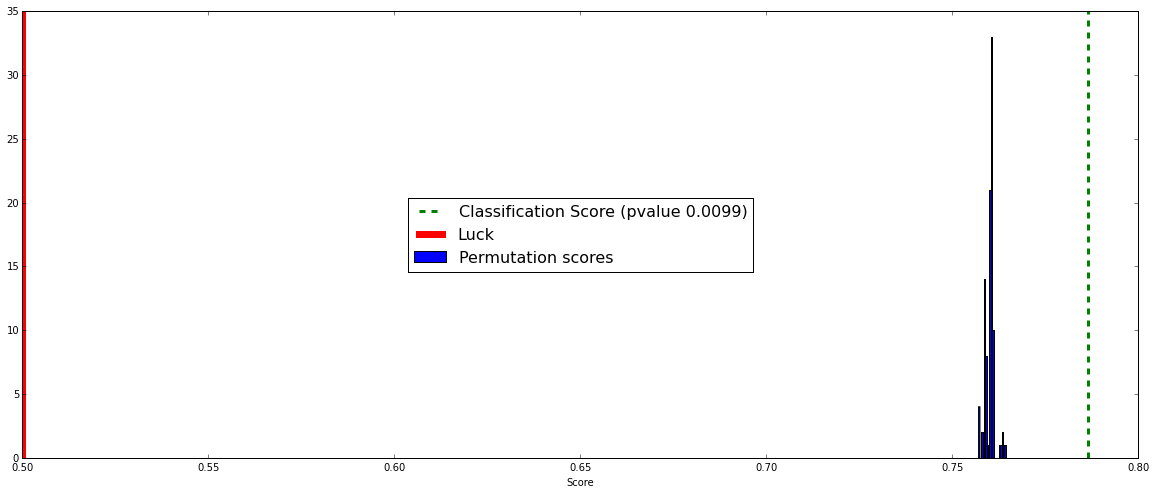

In [12]:
plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')

ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)

In [13]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

voting_ensemble_softWgtd   ,        ,   0.7865 ,  7.3755 , 0.6065 , 0.3692 , 0.7600 , 0.0013


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [14]:
#clf.set_params(**clf_params)
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(init=None, learning_rate=0.15, loss='exponential',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=175,
              pres...ate=97,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0))],
         voting='soft', weights=[1, 0.75, 0.75, 2, 1])

## Load the test data

In [17]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [18]:
y_pred = clf.predict(X_test)
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test)
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[0 0 0 0 1 1 0 0 0 0]
[[ 0.53386636  0.46613364]
 [ 0.85390385  0.14609615]
 [ 0.7004128   0.29958721]
 [ 0.72391782  0.27608219]
 [ 0.4631666   0.5368334 ]
 [ 0.22789016  0.77210984]
 [ 0.63663312  0.36336688]
 [ 0.87954593  0.12045408]
 [ 0.98506669  0.01493331]
 [ 0.95267967  0.04732033]]
[0.46613364447000799, 0.14609615014001676, 0.29958720575167985, 0.27608218508709048, 0.53683340216646158, 0.77210984281716322, 0.36336688007603668, 0.12045407518811148, 0.014933309338141213, 0.047320326540905892]


# Create the submission file

In [19]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()